<a href="https://colab.research.google.com/github/GeorgeLiang3/Hessian-paper/blob/main/Publication_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!git clone https://github.com/GeorgeLiang3/Hessian-paper.git

Cloning into 'Hessian-paper'...
remote: Enumerating objects: 948, done.
remote: Counting objects: 100% (3/3), done.
remote: Total 948 (delta 0), reused 3 (delta 0), pack-reused 945
Receiving objects: 100% (948/948), 55.24 MiB | 21.07 MiB/s, done.
Resolving deltas: 100% (166/166), done.
Checking out files: 100% (926/926), done.


In [5]:
!pip install nptyping==1.0.1
!pip install corner
!pip install Theano

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 45 kB 1.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.8 MB 4.2 MB/s 
  Created wheel for Theano: filename=Theano-1.0.5-py3-none-any.whl size=2668111 sha256=83d8681d808f8c25e42c36b45dd53721c4b79fc1bf1859c3c0b7f904e7a2bd8f
  Stored in directory: /root/.cache/pip/wheels/26/68/6f/745330367ce7822fe0cd863712858151f5723a0a5e322cc144
Successfully built Theano


In [6]:
!pwd

/content


In [8]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU') 
for gpu in gpus: tf.config.experimental.set_memory_growth(gpu, True)


from ipywidgets import interact, interactive
import os
import numpy as np
import sys
import timeit
import csv
sys.path.append('./Hessian-paper/Geophysics/GP_old')
sys.path.append('./Hessian-paper/Geophysics/models')

import matplotlib.pyplot as plt

import gempy as gp
# from gempy.core.tensor.tensorflow_graph_test import TFGraph
from gempy.core.grid_modules.grid_types import CenteredGrid,CenteredRegGrid,RegularGrid

import tensorflow as tf
import tensorflow_probability as tfp
import pandas as pd
from gempy.plot.plot_api import plot_2d
from gempy import create_data, map_series_to_surfaces
from gempy.assets.geophysics import GravityPreprocessing
from gempy.plot.visualization_2d_pro import *
tfd = tfp.distributions
import seaborn as sns
from Model_new import *
from Prob import *


# suppress warinings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)



In [9]:
import seaborn as sns; sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

In [10]:
# tensorflow constant
def constant64(x):
    return tf.constant(x, dtype=tf.float64)
tfconstant = constant64
tfdtype = tf.float64


In [11]:
# define the gravity receiver locations
# X = [200,400,600,800]
# Y = [200,400,600,800]
num_ = 4
X = np.linspace(200,800,num_)
Y = np.linspace(200,800,num_)

r = []
for x in X:
  for y in Y:
    r.append(np.array([x,y]))
receivers = np.array(r)
n_devices = receivers.shape[0]

In [12]:
path = './Hessian-paper/Geophysics/GP_old/notebooks'
orientation_path = "/data/input_data/George_models/model2_1_orientations.csv"
surface_path = '/data/input_data/George_models/'+'model3'+'_surface_points.csv'

regular_grid_resolution = [50,50,50]
center_grid_resolution = [10,10,40]
# model1 = Model(path,surface_path,orientation_path,receivers = receivers,dtype = 'float64')
model_true = Model(path,
              surface_path,
              orientation_path,
              receivers = receivers,
              dtype = 'float64',
              center_grid_resolution=center_grid_resolution,
              regular_grid_resolution=regular_grid_resolution,
              model_radius=[2000,2000,2000])

# plt.savefig('/content/drive/My Drive/RWTH/Figs/layout.png',bbox_inches='tight')

Active grids: ['regular']
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
Active grids: ['regular' 'sections' 'centered']


./Hessian-paper/Geophysics/models/Model_new.py:469: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  [formation_block[l0: l1].numpy(), self.TFG.scalar_matrix[:, l0: l1].numpy().astype(float)])


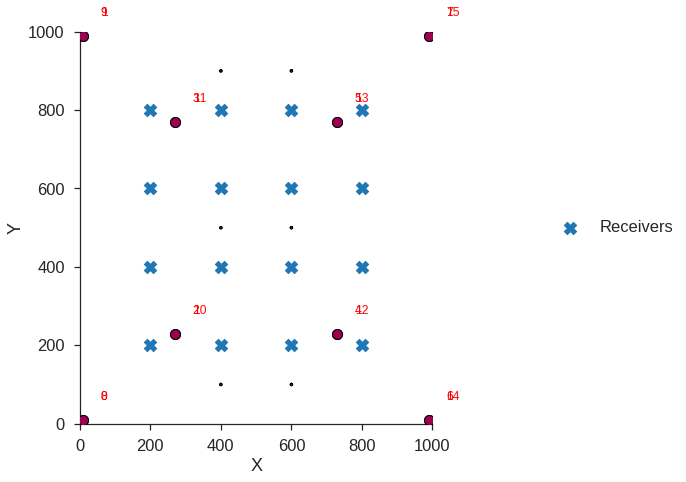

In [13]:
model_true.activate_regular_grid()
model_true.compute_model()
model_true.plot_model()
model_true.monitor=False

1 1.0
cell_number []
x
[0.0, 1000.0, 0.0, 1000.0]


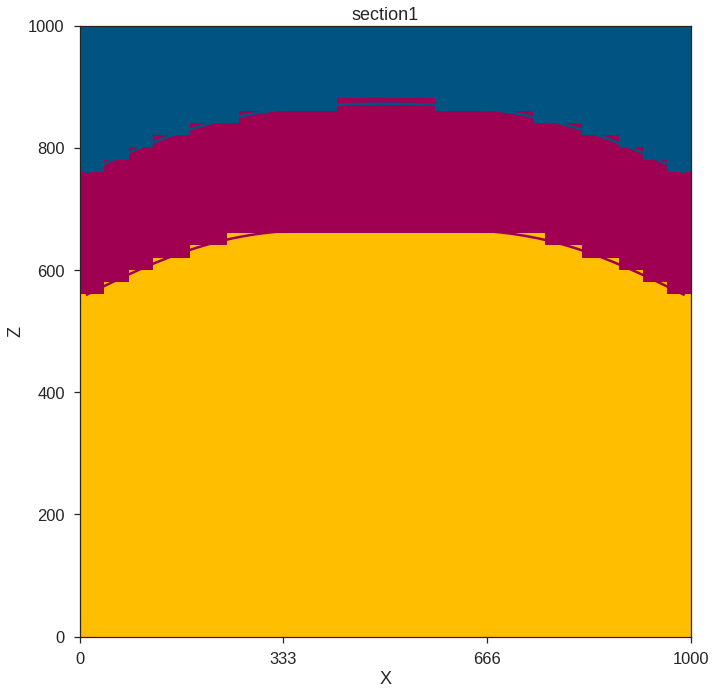

In [15]:
plot_2d(model_true, section_names=['section1'],figsize = (25,10),
        show_data=False, show_boundaries=True, show_lith=True)

In [16]:
model_true.activate_centered_grid()
g = GravityPreprocessing(model_true.grid.centered_grid)
tz = g.set_tz_kernel()

input = model_true.get_graph_input()
model_true.create_tensorflow_graph(input,gradient = True)
size = tf.constant((model_true.center_grid_resolution[0]+1)*(model_true.center_grid_resolution[1]+1)*(model_true.center_grid_resolution[2]),tf.int32)

class gaussianNormalizer(object):
  def __init__(self,mean, std):
    self.mean = mean
    self.std = std
  def normalize(self,mu):
    return (mu-self.mean)/self.std
  def denormalize(self,mu):
    return mu*self.std + self.mean

def forward(mu,model):
    TFG = TFGraph(input, model.fault_drift,
                    model.grid_tensor, model.values_properties, model.nugget_effect_grad,model.nugget_effect_scalar, model.Range,
                    model.C_o, model.rescale_factor,slope = 10, dtype = model.tfdtype, gradient = True)
  
    formation_block,property_block,block_mask =TFG.compute_series(mu,
                model.dips_position,
                model.dip_angles,
                model.azimuth,
                model.polarity,
                model.values_properties)
    
    size_property_block = size*n_devices
    densities = property_block[0:size_property_block]
    grav_convolution_full = tf.TensorArray(model.tfdtype, size=n_devices, dynamic_size=False, clear_after_read=True)
    for i in tf.range(n_devices):
      windowed_densities = densities[i*size:(i+1)*size]
      grav_ = TFG.compute_forward_gravity(tfconstant(tz), 0, size, windowed_densities)
      grav_convolution_full = grav_convolution_full.write(i, grav_)
    grav_convolution_full = tf.squeeze(grav_convolution_full.stack())
    return grav_convolution_full

model_true.grav = forward(model_true.surface_points_coord,model_true)

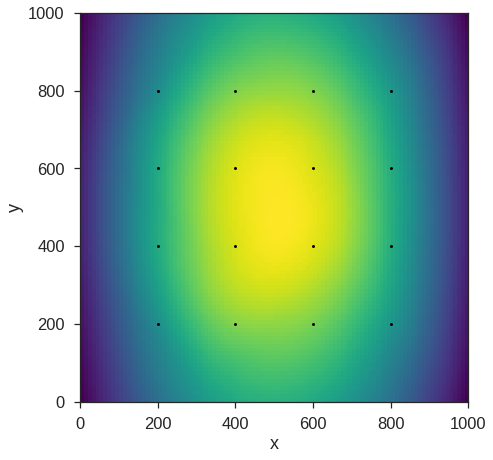

In [17]:
model_true.plot_gravity(receivers)